yes


100%|██████████| 799/799 [00:01<00:00, 622.00it/s]
d:\myPyVenv\myPyVenv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\myPyVenv\myPyVenv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 465/465 [00:00<00:00, 611.84it/s]
d:\myPyVenv\myPyVenv\lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\myPyVenv\myPyVenv\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\myPyVenv\myPyVenv\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
100%|██████████| 186/186 [00:00<00:00, 615.23it/s]
d:\myPyVenv\myPyVenv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWa

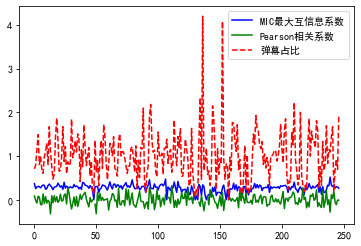

In [24]:
import xml.etree.ElementTree as ET
import json
import pandas as pd
import datetime
from tqdm import tqdm

from minepy import MINE
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

# 用于变换参数之后重新得到最终需要使用的数据
class AlphaAndN:
    def __init__(self, alpha, number):
        self.mine = MINE(alpha=alpha, c=15)
        self.number = number
        self.jsonlis = []
        self.csvlis = []

        self.creatlis()

    def creatlis(self):
        for root, _, files in os.walk('D:\\B站\\录制视频'):
            for file in files:
                if file.endswith('.json'):
                    self.jsonlis.append(os.path.join(root,file))
                elif file.endswith('.csv'):
                    self.csvlis.append(os.path.join(root,file))
        # print(self.jsonlis) 记得去掉前两个json
        self.jsonlis = self.jsonlis[2:]

        flag = True
        for i in range(len(self.jsonlis)):
            if self.jsonlis[i][:-5] != self.csvlis[i][:-18]: flag = False
        
        if flag:
            print('yes')
        else:
            print('no')

    def all_calculate(self):
        for i in range(len(self.jsonlis)):
            self.one_calculate(i)
    
    def my_time(self, timestamp): # 后面会用到
        return datetime.datetime.fromtimestamp(timestamp)

    def my_emotion(self, pos, neg): # 后面会用到
        pos_and_neg = pos+neg
        if(pos_and_neg == 0): return 0.5
        else: return 1.0*pos/pos_and_neg

    def one_calculate(self, i):
        df = pd.read_json(self.jsonlis[i]) # 就不保存了直接用吧！
        
        keep_fields = ['p', 'd'] # d 弹幕内容 p列第五个数据为时间戳 取前10位数字
        df = df[keep_fields]

        df['timestamp'] = df['p'].str.split(',').str[4].str[:10].astype(int)

        df['time'] = df.timestamp.apply(self.my_time)
        df = df[['d', 'time']]

        # 进行简单的情感分析：情感词典打分
        # 下面使用一个台湾的中央研究所开发的情感词典（简体字）
        emo = pd.read_csv('C:\\Users\\杨军\\Desktop\\科研课堂\\dmp-main\\data\\opinion_word_simplified.csv',
                   names = 'word score pos neu neg non not'.split())
        
        # 先使用 正面pos 和 负面 neg
        pos_words = {}
        neg_words = {}

        for item in emo.itertuples():
            if item.pos > 0: pos_words[item.word] = item.pos
            elif item.neg > 0: neg_words[item.word] = item.neg


        pos_score_arr = []
        neg_score_arr = []

        for sentence in tqdm(list(df.d)):
            pos_scores = []
            neg_scores = []
    
            for pos_w, pos_score in pos_words.items():
                if pos_w in sentence: 
                    pos_scores.append(pos_score)
            for neg_w, neg_score in neg_words.items():
                if neg_w in sentence: 
                    neg_scores.append(neg_score)

            pos_score = sum(pos_scores)
            neg_score = sum(neg_scores)

            pos_score_arr.append(pos_score)
            neg_score_arr.append(neg_score)

        df['pos_score'] = pos_score_arr
        df['neg_score'] = neg_score_arr
        
        df.index = df.time
        
        # number
        df3 = df.resample('8s').d.aggregate('count')# 为了匹配后面的代码 df3 虽然用不了了
        df3.to_csv('D:/myPyVenv/21377222/final/WithnumberOfDanmu.csv', index=True, encoding='utf-8') # 会直接清空在书写
        
        self.df3 = pd.read_csv('D:/myPyVenv/21377222/final/WithnumberOfDanmu.csv', low_memory=False, encoding='utf-8') # 弹幕数量 与 df2 的长度天然一致
        
        # 情感指数
        df = df[['pos_score', 'neg_score']].resample('8s').aggregate('sum')
        df['情感指数'] = df.apply(lambda row : self.my_emotion(row['pos_score'], row['neg_score']), axis=1)
        
        self.df2 = df

        self.df1 = pd.read_csv(self.csvlis[i])
        self.df1 = self.df1.sort_values(by='time')

        self.X = self.df1['情感指数'] # 主播端
        self.Y = self.df2['情感指数'] # 观众端
        self.Z = self.df3['d']
        
        self.length = min(len(self.X), len(self.Y))
        
        if(len(self.X) > self.length):
            self.X = self.X[:self.length]
        if(len(self.Y) > self.length):
            self.Y = self.Y[:self.length]
            self.Z = self.Z[:self.length]
        
        self.mic_number_to_csv()

    def mic_number_to_csv(self):
        # 计算MIC和弹幕数量
        number = self.number # 后面代码就不修改了
        MIC = []
        
        r = []

        Danmu = []
        i = number # 在判断时可以防止越界访问 后续对最后一个数据好操作
        while(i<self.length):
            x = self.X[i-number:i]
            y = self.Y[i-number:i]
            
            self.mine.compute_score(x, y)
            MIC.append(self.mine.mic())

            r.append(np.corrcoef(x,y)[0,1])

            Danmu.append(sum(self.Z[i-number:i]))
            i+=number
        x = self.X[i-number:] # 最后一个
        y = self.Y[i-number:]
        self.mine.compute_score(x, y)
        MIC.append(self.mine.mic())

        r.append(np.corrcoef(x,y)[0,1])

        Danmu.append(sum(self.Z[i-number:]))
        df = pd.DataFrame()
        df['MIC最大互信息系数'] = MIC

        df['Pearson相关系数'] = r

        df['弹幕数量'] = Danmu
        total_number = sum(Danmu)
        df['弹幕占比'] = df.apply(lambda row: 1.0*self.length*row['弹幕数量']/(total_number*number), axis=1)
        # 平均状态下为 1 看 相对于平均状态其程度
        # 对最后一个数据进行特殊处理
        df.at[df.index[-1], '弹幕占比'] = 1.0*self.length*Danmu[-1]/(total_number*(self.length-i+number))

        if(os.path.exists('D:/myPyVenv/21377222/final/MICandNumber.csv')):
            df.to_csv('D:/myPyVenv/21377222/final/MICandNumber.csv', mode='a', header=False, index=False, encoding='utf-8') # header 去掉追加的头
        else:
            df.to_csv('D:/myPyVenv/21377222/final/MICandNumber.csv', index=False, encoding='utf-8')
        
        # self.mic_number() # 每计算一次都看看图

    def mic_number(self):
        df = pd.read_csv('D:/myPyVenv/21377222/final/MICandNumber.csv', low_memory=False, encoding='utf-8')
        fig = plt.figure()
        ax1=fig.subplots()
        ax2=ax1.twinx()

        ax1.plot(df.index.values, df['MIC最大互信息系数'].values, linestyle='-', label='MIC最大互信息系数', color='b')
        
        ax1.plot(df.index.values, df['Pearson相关系数'].values, linestyle='-', label='Pearson相关系数', color='g')
        ax1.legend(loc='upper left')

        ax2.plot(df.index.values, df['弹幕占比'].values, linestyle='--', label='弹幕占比', color='r')

        ax2.legend(loc='upper right')
        plt.show()


a = AlphaAndN(alpha=0.68, number=80)
a.all_calculate()
a.mic_number()

# 绘制观看动态变化和变化趋势

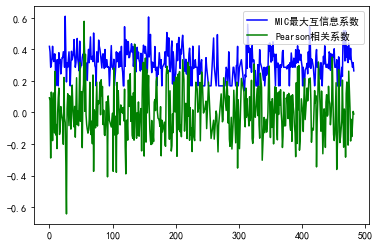

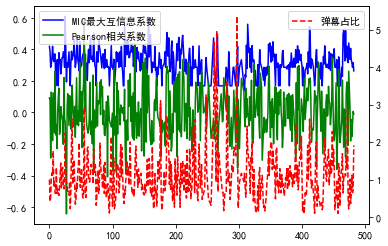

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

class Show:
    def __init__(self, path):
        df = pd.read_csv(path, low_memory=False, encoding='utf-8')
        self.df = df.dropna(axis=0, how='any')
        self.show_two()
        self.show_three()

    def show_two(self):
        df = self.df
        
        plt.plot(df.index.values, df['MIC最大互信息系数'].values, linestyle='-', label='MIC最大互信息系数', color='b')
        
        plt.plot(df.index.values, df['Pearson相关系数'].values, linestyle='-', label='Pearson相关系数', color='g')

        plt.legend(loc='upper right')
        plt.show()

        #print(np.var(df['MIC最大互信息系数'].values, ddof = 1))
        #print(np.var(df['Pearson相关系数'].values, ddof=1))

    def show_three(self):
        df = self.df

        fig = plt.figure()
        ax1=fig.subplots()
        ax2=ax1.twinx()  

        ax1.plot(df.index.values, df['MIC最大互信息系数'].values, linestyle='-', label='MIC最大互信息系数', color='b')
        
        ax1.plot(df.index.values, df['Pearson相关系数'].values, linestyle='-', label='Pearson相关系数', color='g')
        ax1.legend(loc='upper left')

        ax2.plot(df.index.values, df['弹幕占比'].values, linestyle='--', label='弹幕占比', color='r')

        ax2.legend(loc='upper right')
        plt.show()

a = Show(path='D:/myPyVenv/21377222/final/MICandNumber_alpha=0.68andn=40.csv')